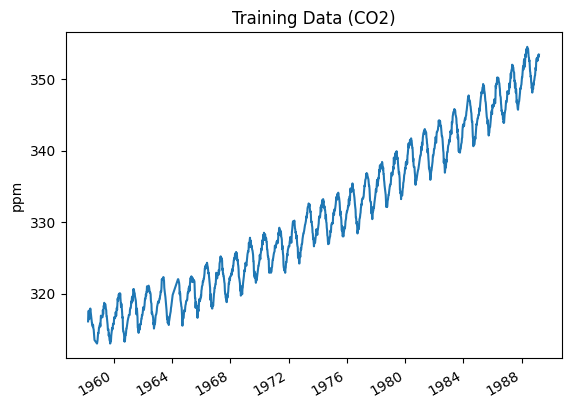

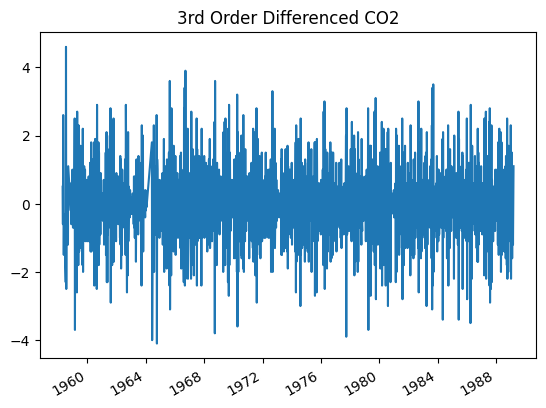

ADF Test Result on 3rd Differenced Series:
ADF Statistic: -15.1399
p-value: 0.0000
--------------------------------------------------


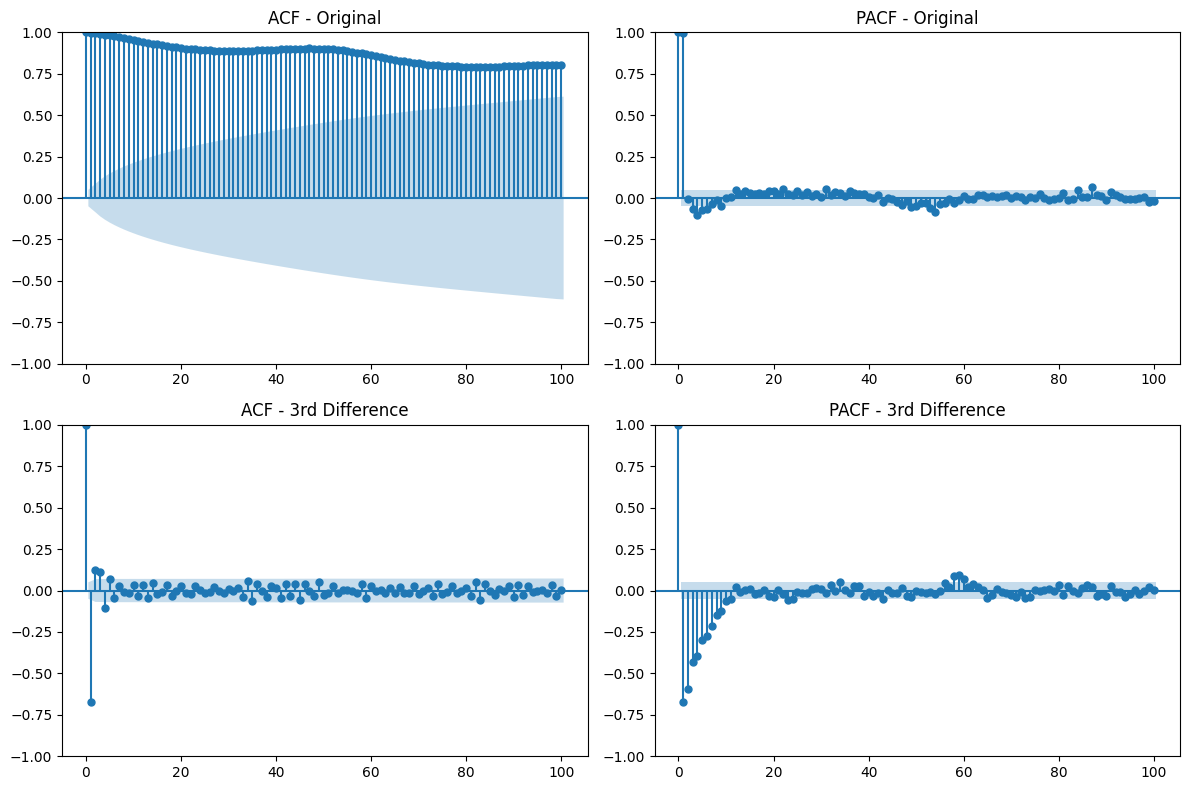

C:\Users\DS-31\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\DS-31\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\DS-31\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\DS-31\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been pro

AIC Comparison:
                 AIC Score
ARIMA(12,2,0)  2049.085980
ARIMA(12,2,1)  1923.408655
ARIMA(12,2,2)  1937.577759

AIC Differences:
Model1 vs Model2: 125.67732505021263
Model1 vs Model3: 111.50822113848517
Model2 vs Model3: 14.169103911727461
--------------------------------------------------


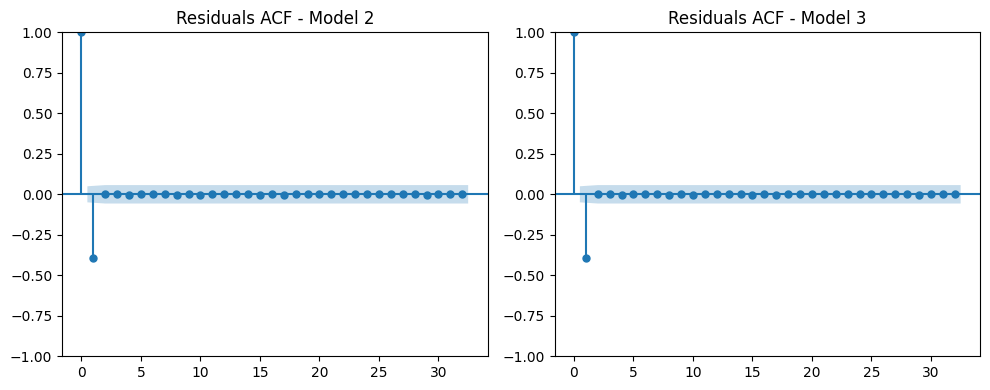

C:\Users\DS-31\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\DS-31\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


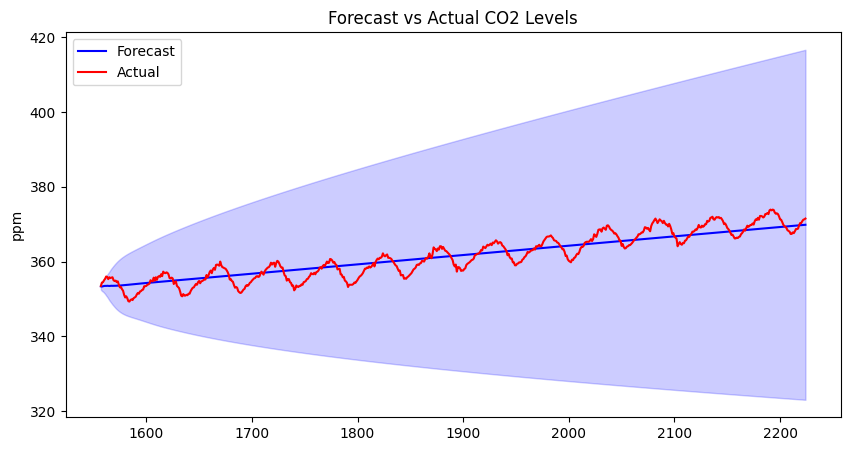

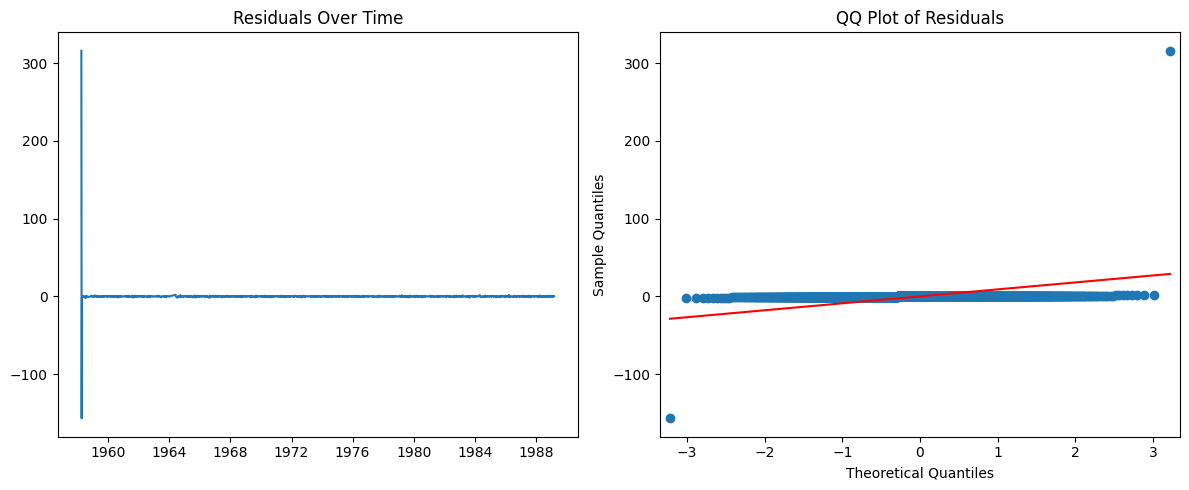

Ljung-Box Test for Autocorrelation in Residuals:
       lb_stat     lb_pvalue
10  244.722856  6.978892e-47


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# Load real CO2 data (similar to cardox from R)
data = sm.datasets.co2.load_pandas().data
cardox = data['co2'].dropna()

# Optional: Interpolate missing values if needed
cardox = cardox.interpolate()

# Train-test split (70% train, 30% test)
split_index = int(0.7 * len(cardox))
train_data = cardox[:split_index]
test_data = cardox[split_index:]

# Plot training data
plt.figure()
train_data.plot(title='Training Data (CO2)', ylabel='ppm')
plt.show()

# Apply third difference
diff_data = train_data.diff().diff().diff().dropna()

# Plot 3rd difference
plt.figure()
diff_data.plot(title='3rd Order Differenced CO2')
plt.show()

# ADF Test for stationarity
adf_result = adfuller(diff_data)
print("ADF Test Result on 3rd Differenced Series:")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print('-'*50)

# ACF and PACF plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(train_data.dropna(), lags=100, ax=axs[0, 0])
axs[0, 0].set_title('ACF - Original')
plot_pacf(train_data.dropna(), lags=100, ax=axs[0, 1])
axs[0, 1].set_title('PACF - Original')
plot_acf(diff_data, lags=100, ax=axs[1, 0])
axs[1, 0].set_title('ACF - 3rd Difference')
plot_pacf(diff_data, lags=100, ax=axs[1, 1])
axs[1, 1].set_title('PACF - 3rd Difference')
plt.tight_layout()
plt.show()

# Fit ARIMA models on 2nd differenced data
model1 = ARIMA(train_data, order=(12, 2, 0)).fit()
model2 = ARIMA(train_data, order=(12, 2, 1)).fit()
model3 = ARIMA(train_data, order=(12, 2, 2)).fit()  # Same as model1

# Compare AIC scores
aic_df = pd.DataFrame({
    'AIC Score': [model1.aic, model2.aic, model3.aic]
}, index=['ARIMA(12,2,0)', 'ARIMA(12,2,1)', 'ARIMA(12,2,2)'])
print("AIC Comparison:")
print(aic_df)
print("\nAIC Differences:")
print("Model1 vs Model2:", abs(model1.aic - model2.aic))
print("Model1 vs Model3:", abs(model1.aic - model3.aic))
print("Model2 vs Model3:", abs(model2.aic - model3.aic))
print('-'*50)

# ACF of residuals
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_acf(model2.resid, ax=axs[0])
axs[0].set_title("Residuals ACF - Model 2")
plot_acf(model3.resid, ax=axs[1])
axs[1].set_title("Residuals ACF - Model 3")
plt.tight_layout()
plt.show()

# Forecast with the better model (say model2)
forecast_steps = len(test_data)
forecast_result = model2.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# Plot forecast vs actual
plt.figure(figsize=(10, 5))
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='blue')
plt.plot(forecast_mean.index, test_data, label='Actual', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='blue', alpha=0.2)
plt.title("Forecast vs Actual CO2 Levels")
plt.ylabel("ppm")
plt.legend()
plt.show()

# Residual diagnostics
residuals = model2.resid

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.subplot(1, 2, 2)
qqplot(residuals, line='s', ax=plt.gca())
plt.title("QQ Plot of Residuals")
plt.tight_layout()
plt.show()

# Ljung-Box test
ljung_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box Test for Autocorrelation in Residuals:")
print(ljung_result)
